# Read and plot DTS data
This notebook shows how to read DTS data from a .csv file and plot it.

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary

# import cv2

# matplotlib.use('TkAgg')
%matplotlib inline

# Set up data

In [2]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [3]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [4]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [8]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = start_time # datetime.datetime(2023, 8, 24, 16) # 25
endt = end_time # datetime.datetime(2023, 8, 26, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
# for i in range(len(filtered_arr[0, :])): filtered_arr[:, i] = filtered_arr[:, i] - filtered_arr[0, i]
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

## Temperature plotted data

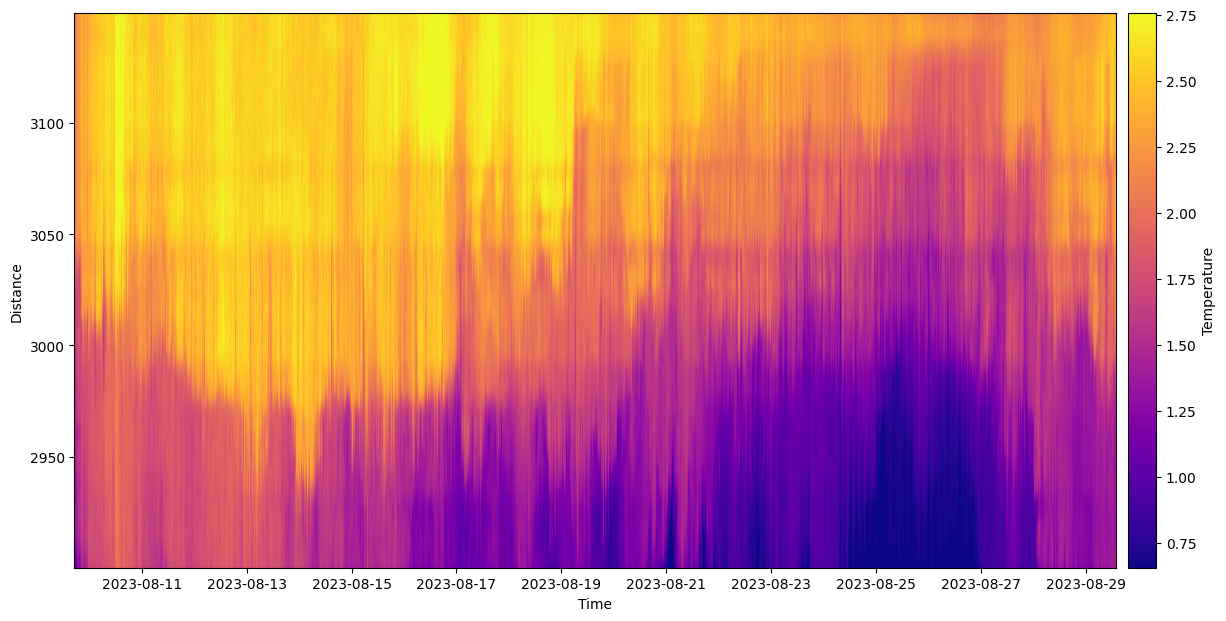

In [9]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

# Detecting the amplitude of the waves

## Making my own contours

In [12]:


n_contours = 100
contour_values = np.linspace(0.55, 2.2, n_contours) # 0.55
contour_values_legend = []
for i in range(len(contour_values)): contour_values_legend.append(str(contour_values[i]) + "ºC")

contour_points = {}
contour_points_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
# np.empty((len(contour_values), len(filtered_arr[:, 1])))
nan_inds = {}
real_inds = {}
depths_arr = np.empty((len(contour_values), len(plot_times_zoomed)))
cvi = 0

for cv in contour_values:
    avg_zero_crossings = 0
    nan_inds[cvi] = []
    real_inds[cvi] = []
    contour_points[cv] = {}
    contour_points[cv]['x'] = []
    contour_points[cv]['t'] = []
    for i in range(len(filtered_arr[:, 0])):
        xc = pyaC.zerocross1d(plot_dists_zoomed, filtered_arr[i, :] - cv)
        if(len(xc) == 1):
            real_inds[cvi].append(i)
            contour_points_arr[cvi, i] = xc.flatten().tolist()[0]
            contour_points[cv]['x'].extend(xc.flatten().tolist())
            contour_points[cv]['t'].extend(np.full(len(xc), plot_times_zoomed_int[i]).tolist())
        else:
            nan_inds[cvi].append(i)
            contour_points_arr[cvi, i] = float('NaN')
        avg_zero_crossings = avg_zero_crossings + len(xc)
    # print('Temp contour =', cv, 'avg of', avg_zero_crossings/len(filtered_arr[:, 0]), 'zero crossings')
    
    nan_inds[cvi] = np.array(nan_inds[cvi])
    real_inds[cvi] = np.array(real_inds[cvi])

    cvi = cvi + 1

contour_points_arr_interp = np.empty( (n_contours, len(plot_times_zoomed)) )
depths = np.nanmedian(contour_points_arr, axis=1)
depths_interp = np.linspace(plot_dists_zoomed[0], plot_dists_zoomed[-1], len(contour_points_arr_interp[:, 0]))

for i in range(len(contour_points_arr[0, :])):
    real_inds = np.where(~np.isnan(contour_points_arr[:, i]))[0]
    contour_points_arr_interp[:, i] = np.interp(depths_interp, depths[real_inds], contour_points_arr[real_inds, i])

# np.interp(xc, plot_dists_zoomed, filtered_arr[i, :])

## Plotting

In [15]:
depths = np.empty(np.shape(contour_points_arr_interp))
displacements = np.empty(np.shape(contour_points_arr_interp))

filter = scipy.signal.butter(1, 0.5, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate. Used to be 0.5 cutoff

for i in range(len(contour_points_arr_interp[:, 0])):
    depths[i, :] = depths_interp[i]
    # High pass filter each channel
    # contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
    displacements[i, :] = contour_points_arr_interp[i, :]  - np.mean(contour_points_arr_interp[i, :])
    # displacements[i, :] = contours_high_pass #contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :])   #  contours_high_pass

# displacements = contour_points_arr_interp - np.median(contour_points_arr_interp)
## Normalize displacements ## 
displacements = (displacements - np.min(displacements)) / (np.max(displacements) - np.min(displacements))
displacements = 2 * displacements - 1

i = 60 # np.absolute(depths - 3027).argmin()
contours_high_pass = scipy.signal.sosfilt(filter, contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))

# fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# ax.plot(displacements[i, :])
# ax.plot(contour_points_arr_interp[i, :] - np.median(contour_points_arr_interp[i, :]))
# # ax.plot(contour_points_arr[i, :] - np.median(contour_points_arr[i, :]))
# ax.legend(['High Pass', 'Original'])

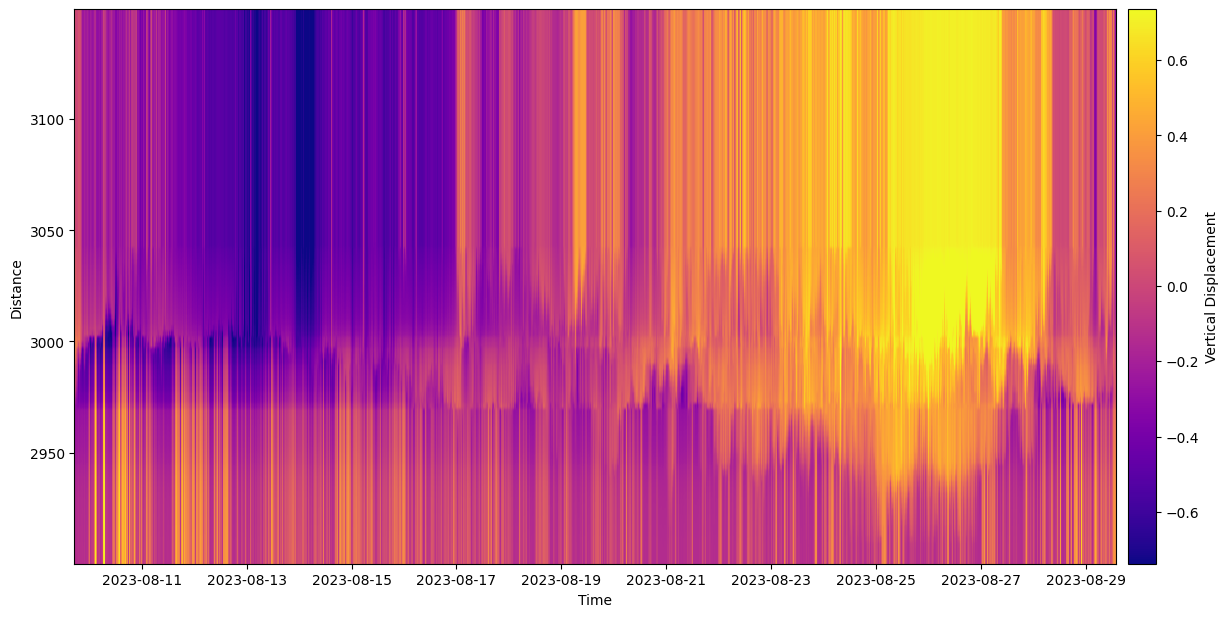

In [16]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(displacements[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + displacements[i, :])
ddt = np.gradient(displacements, axis=1)
im1 = ax.imshow(displacements, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(displacements[~np.isnan(displacements)],1),
            vmax=np.percentile(displacements[~np.isnan(displacements)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


# Set up SINDy

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## SINDy Stuff

## Trying with original method (not weak)

In [198]:
def get_coefs(x, t, displacements, sparsity):
    dt = t[1] - t[0]
    dx = x[1] - x[0]

    u_sol = displacements
    v_sol = ps.SmoothedFiniteDifference(axis=1)._differentiate(u_sol, t=dt)

    u = np.zeros((len(x), len(t), 2))
    u[:, :, 0] = u_sol
    u[:, :, 1] = v_sol
    u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

    train = range(0, int(len(t) * 0.6))
    test = [i for i in np.arange(len(t)) if i not in train]
    u_train = u[:, train, :]
    u_test = u[:, test, :]
    u_dot_train = u_dot[:, train, :]
    u_dot_test = u_dot[:, test, :]
    t_train = t[train]
    t_test = t[test]

    library_functions = [
        lambda x: x,
        lambda x: x * x * x,
        lambda x, y: x * y * y,
        lambda x, y: x * x * y,
    ]
    library_function_names = [
        lambda x: x,
        lambda x: x + x + x,
        lambda x, y: x + y + y,
        lambda x, y: x + x + y,
    ]
    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatial_grid=x,
        include_bias=True,
        is_uniform=True,
        periodic=True
    )

    optimizer = ps.STLSQ(
        threshold=sparsity, # 8e-2
        max_iter=10000,
        normalize_columns=True,
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u_train, x_dot=u_dot_train, ensemble=False, quiet=True)
    # model.print()
    # u_dot_sr3 = model.predict(u_test)

    # Get the coefficients
    coefficients = model.coefficients()

    # Get the term names
    feature_names = model.get_feature_names()
    # fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
    # plt.plot(feature_names, np.abs(coefficients[1, :]), 'o')
    # plt.xticks(fontsize=6)
    # plt.yscale('log')
    # print(coefficients[1, :])
    # print(feature_names)
    return feature_names, coefficients[1, :]
    # for i, feature in enumerate(feature_names):
        # print(f"Term: {feature}, Coefficient: {coefficients[1][i]}")

In [217]:
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths[:, 0] - depths[0, 0] # grid_y[0, :]
window_size = 400
step_size = 10
n_segments = int(len(t)/step_size) - 1
feature_names, temp = get_coefs(x, t[0:100], displacements[:, 0:100], 4e-2)
coefficients = np.empty((len(temp), n_segments))
segment_t = []


for i in range(int(len(t)/step_size) - 1):
    start_t_ind = i*step_size# int(i * (len(t)/(n_segments)))
    end_t_ind = i*step_size + window_size # int((i+1) * (len(t)/(n_segments)))
    if(end_t_ind > len(t) - 1): end_t_ind = len(t) - 1
    segment_t.append(plot_times_zoomed[int((start_t_ind + end_t_ind)/2)])
    feature_names, coefficients[:, i] = get_coefs(x, t[start_t_ind:end_t_ind], displacements[:, start_t_ind:end_t_ind], 4e-2)
    coefficients[:, i] = np.array([x if(x <= 1e4 and x >= -1e4 )else 0 for x in coefficients[:, i]])

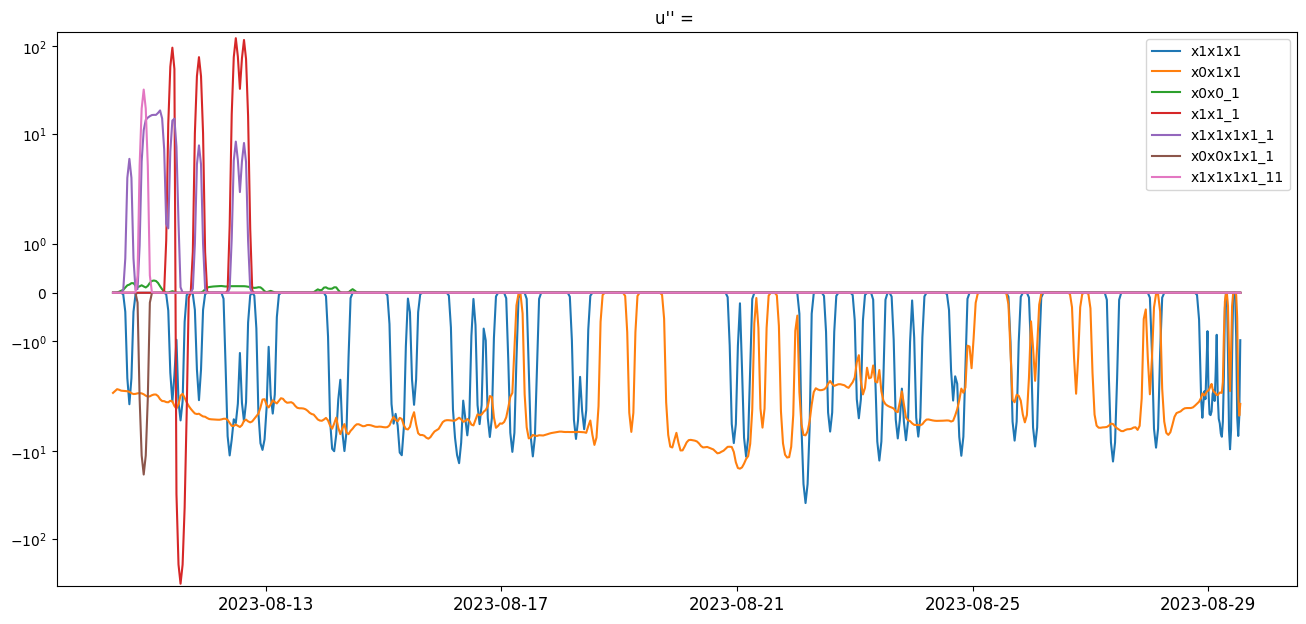

In [218]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
for i in range(len(feature_names)): 
    if(np.average(np.abs(coefficients[i, :])) > 1e-2): plt.plot(segment_t, scipy.ndimage.gaussian_filter1d(coefficients[i, :], 1), '-', label=feature_names[i])
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
plt.title("u'' = " )
plt.xticks(fontsize=12)
# plt.xlim(segment_t[0], segment_t[-1])
plt.yscale('symlog')
# plt.ylim([-1e-1, 1e-1])
plt.legend()

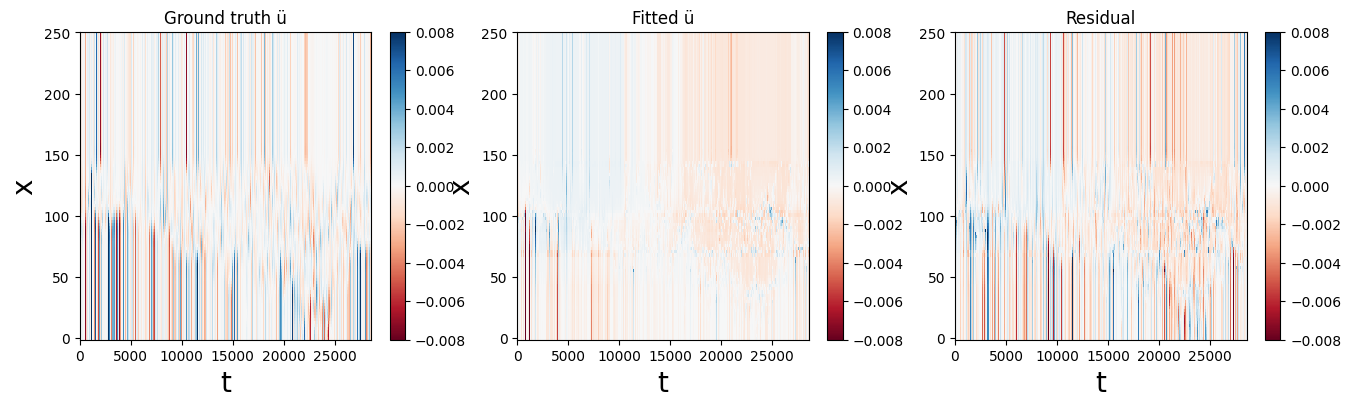

In [22]:
u_dot_pred = model.predict(u)
model_num = 1
min = -8e-3
max = 8e-3
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot[:, :, model_num], vmin=min, vmax=max, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth ü')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], vmin=min, vmax=max, shading='nearest', cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted ü')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,model_num], vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()

## Weak formulation

In [77]:
# Example data (replace with your actual data)
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths[:, 0] - depths[0, 0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = displacements


u = np.zeros((len(x), len(t), 1))
u[:, :, 0] = u_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)


In [78]:
# Define PDE library that is quadratic in u, and 
# third-order in spatial derivatives of u.
spatiotemporal_grid=np.zeros((len(x),len(t),2))
spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
np.random.seed(1)

In [79]:
multiindices=np.array([[0,1],[0,2],[1,0],[2,0]])
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=x, temporal_grid=t,
                        include_bias=True, is_uniform=True,implicit_terms=True, multiindices=multiindices)

sindy_opt = ps.SINDyPI(
    threshold=1e-1, max_iter=1000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)
model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()
# print('score', model.score(u,t=dt))

Model  0


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 0, try changing your library
  warnings.warn(


Model  1


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 1, try changing your library
  warnings.warn(


Model  2
Solver failed on model  2 , setting coefs to zeros
Model  3
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Solver failed on model  12 , setting coefs to zeros
Model  13
Model  14
1 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0x0 = 0.000
x0_t = -0.001 x0 + -0.002 x0x0 + -0.276 x0x0_t + 3.376 x0x0x0_t
x0_tt = -0.005 x0 + -0.004 x0x0 + 0.005 x0_1 + 0.145 x0_11 + -0.049 x0x0_tt + 2.107 x0x0x0_tt
x0_1 = -0.001 x0x0 + 0.010 x0_tt + -0.082 x0_11 + -0.005 x0x0_tt + -0.037 x0x0_1 + 4.214 x0x0x0_1
x0_11 = -0.001 x0 + -0.001 x0x0 + 0.104 x0_tt + -0.020 x0_1 + -0.123 x0x0_1 + -0.116 x0x0_11 + 2.223 x0x0x0_11
x0x0_t = 0

In [81]:
lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)


scores=[r2_score(np.reshape(lhs_actual[:,:,ind],(np.product(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.product(lhs_actual.shape[:-1])))) for ind in range(lhs_predict.shape[-1])]

plt.plot(scores,'bo')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))

ValueError: Input contains NaN.

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_86822/323179050.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Ground truth $\dot{u}$')
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_86822/323179050.py:25: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Fitted $\dot{u}$')


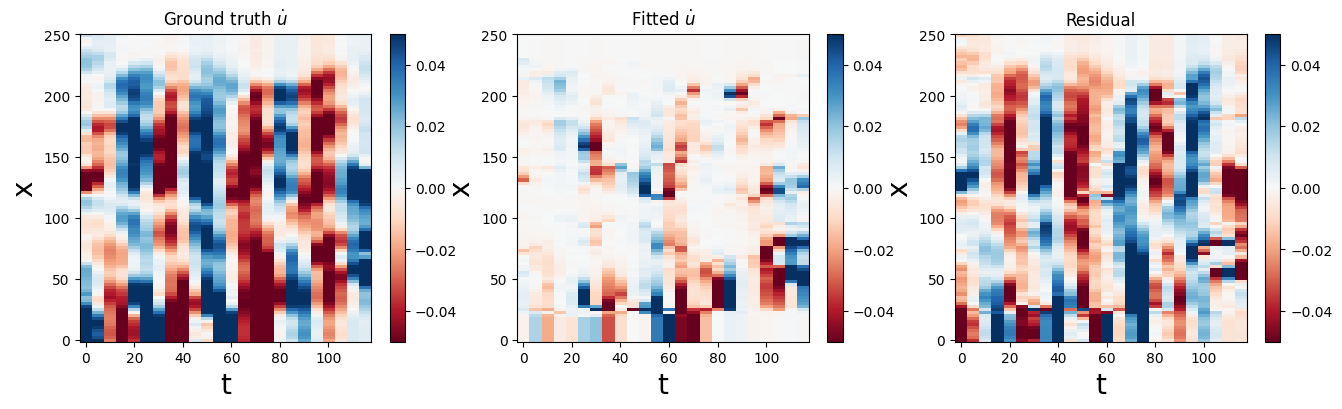

In [ ]:
u_dot_pred = model.predict(u)
model_num = 3
min = -5e-2
max = 5e-2
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot[:, :, 0], shading='nearest', vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth $\dot{u}$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], shading='nearest', vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted $\dot{u}$')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,0], vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()